# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [2]:
from setup import *

In [3]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/01 12:30:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/01 12:30:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/01 12:30:05 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/04/01 12:30:05 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/04/01 12:30:05 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


## Load regions

In [4]:
indy = Region.load('Indianapolis', 'Indiana')
aus = Region.load('Austin', 'Texas')
hous = Region.load('Houston', 'Texas')

rgns = [indy, aus, hous]

In [5]:
for rgn in rgns:
    rgn.boundary = gpd.read_file(rgn.geom / 'city_limit.gpkg')

# $A_0$: Simple centroid
Home location is the centroid of the all-time nighttime data.

In [6]:
P.params.set({'algorithms': {'A0': {
    'name': 'Simple centroid',
    'description': 'Home location is the centroid of the all-time nighttime data.'
}}})

In [7]:
def get_homes_a0(rgn, save=False):
    df = SP.read_parquet(rgn.data / 'night_pings').groupby(UID).agg(*[
        F.flatten(F.collect_list(x)).alias(x) for x in [LON, LAT]])
    df = df.select(UID, *[F.udf(lambda x: sum(x)/len(x), T.float)(x).alias(x) 
                          for x in [LON, LAT]])
    if save:
        outpath = U.mkdir(rgn.data / 'home_locs') / 'A0.parquet'
        df = df.toPandas().to_parquet(outpath)
    return df

In [8]:
# %time indy.h0 = get_homes_a0(indy, save=True) # t=14s
# %time aus.h0 = get_homes_a0(aus, save=True) # t=6s
# %time hous.h0 = get_homes_a0(hous, save=True) # t=19s

# $A_1$: All-time clustering
Home location is the center of the largest cluster of all-time nighttime data.

In [9]:
# import json
# from pqdm.processes import pqdm
from sklearn.cluster import MeanShift

## Parameters

In [10]:
cluster_radius = 500 # meters
# parameters for MeanShift clustering
ms_params = dict(
    bin_seeding = True,
    min_bin_freq = 2,
    max_iter = 30,
    cluster_all = False
)

In [11]:
P.params.set({'algorithms': {'A1': {
    'name': 'All-time clustering',
    'description': 'Home location is the center of the largest cluster of all-time nighttime data based on MeanShift clustering.',
    'meanshift': {'clustering_radius': cluster_radius} | ms_params
}}})

## Define method

In [12]:
def meanshift_single(x, y, bw: float, kwargs=ms_params):
    try:
        model = MeanShift(bandwidth=bw, **kwargs)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            model.fit(np.vstack([x, y]).T)
        return model.cluster_centers_[0].tolist() + [False]
    except ValueError:
        return [float(np.mean(x)), float(np.mean(y))] + [True]

In [13]:
def get_homes_a1(rgn, radius=cluster_radius, ms_params=ms_params):
    df = SP.read_parquet(rgn.data / 'night_pings').groupby(UID).agg(*[
        F.flatten(F.collect_list(x)).alias(x) for x in [LON, LAT]])
    df = df.toPandas()
    res = []
    for _, r in tqdm(df.iterrows(), total=df.shape[0]):
        bandwidth = mk.geo.dist_m2deg(radius, np.mean(r[LAT]))
        res.append([r[UID]] + meanshift_single(r[LON], r[LAT], bandwidth))
    res = Pdf(res, columns=[UID, LON, LAT, 'used_mean'])
    res.to_parquet(U.mkdir(rgn.data / 'home_locs') / 'A1.parquet')
    return res
    
# %time x1 = get_homes_a1(indy); x1

## Run method

In [14]:
# %time indy.h1 = get_homes_a1(indy) # t=47:42
# %time aus.h1 = get_homes_a1(aus) # t=33:15
# %time hous.h1 = get_homes_a1(hous) # t~=2:00:00

# $A_2$: Superping clustering
For each ½-hour slot, the pings are aggregated to just the mean "super-ping". If `max_rg` is supplied, only superpings with radius of gyration smaller than this amount are filtered. The created/filtered superpings are finally clustered and the largest cluster center is chosen as the home location.

In [15]:
P.params.set({'algorithms': {'A2': {
    'name': 'All-time clustering',
    'description': 'For each ½-hour slot, the pings are aggregated to just the mean “super-ping“. The created/filtered superpings are finally clustered and the largest cluster center is chosen as the home location.',
    'meanshift': {'clustering_radius': cluster_radius} | ms_params
}}})

In [16]:
def get_homes_a2(rgn, radius=cluster_radius, max_rg=None, process=True):
    df = SP.read_parquet(rgn.data / 'night_superpings')
    if type(max_rg) in [int, float]:
        df = df.filter(f'rg <= {max_rg}')
        P.params.set('algorithms.A2b', dict(
            name='Superping clustering with max rg',
            description='Same as A2 but with a maximum limit on radius of gyration of each superping.',
            max_rg=max_rg))
    if not process: return
    df = df.groupby(UID).agg(*[F.collect_list('mean_'+x).alias(x) for x in [LON, LAT]])
    df = df.toPandas()
    res = []
    for _, r in tqdm(df.iterrows(), total=df.shape[0]):
        bandwidth = mk.geo.dist_m2deg(radius, np.mean(r[LAT]))
        res.append([r[UID]] + meanshift_single(r[LON], r[LAT], bandwidth))
    res = Pdf(res, columns=[UID, LON, LAT, 'used_mean'])
    fname = 'A2' if max_rg is None else 'A2b'
    res.to_parquet(rgn.data / f'home_locs/{fname}.parquet')
    return res
    
x2 = get_homes_a2(indy, process=False); x2

## Without any $r_g$ filter

In [17]:
# %time indy.h2 = get_homes_a2(indy) # t=9:46
# %time aus.h2 = get_homes_a2(aus) # t=6:06
# %time hous.h2 = get_homes_a2(hous) # t=20:14

## With $r_g$ filter

In [18]:
# %time indy.h2b = get_homes_a2(indy, max_rg=200) # t=9:24
# %time aus.h2b = get_homes_a2(aus, max_rg=200) # t=5:40
# %time hous.h2b = get_homes_a2(hous, max_rg=200) # t=19:36

# $A_3$: Stay point method
From [Saged et al. (2019)](https://doi.org/10.1061/9780784482438.002)

In [19]:
indy.dates = U.dates('2021-03-01', '2021-03-07')
aus.dates = U.dates('2021-07-01', '2021-07-07')
hous.dates = U.dates('2021-07-01', '2021-07-07')

## Parameters

In [20]:
day_hrs = (6, 21) # 6 AM – 9 PM
min_pts = 20 # minimum total points in nighttime
dist_thresh = 250 # meters
time_thresh = 30*60 # seconds
intra_clust_dist = 250 # meters
min_total_duration = 24*3600 # seconds
min_night_duration = 3*3600 # seconds

In [21]:
import haversine as hs

from sklearn.cluster import AgglomerativeClustering

## Main method: Extract using stay regions

In [22]:
df = SP.read_parquet(aus.data / 'pings/2021-07-03').limit(1000).toPandas()

### Define method

In [23]:
def get_stay_points(x, y, t, dist_thresh=dist_thresh,
                    time_thresh=time_thresh):
    stay_pts = []
    i = 0
    while i < len(x):
        j = i + 1
        while j < len(x):
        # for j in range(i+1, len(x)):
            dist = float(hs.haversine((y[i], x[i]), (y[j], x[j]), unit='m'))
            if dist > dist_thresh:
                if t[j] - t[i] > time_thresh:
                    coord = [sum(a[i:j])/(j-i) for a in [x, y]]
                    stay_pts.append({
                        LON: sum(x[i:j])/(j-i), LAT: sum(y[i:j])/(j-i),
                        TS+'_arr': t[i], TS+'_dep': t[j]})
                i = j
                break
            j += 1
        if j == len(x):
            break
    return stay_pts

r = df.iloc[797]
print(r.lon.size)
# x = get_stay_points(r.lon, r.lat, r.ts); x

483


[{'lon': -97.7748467091764,
  'lat': 30.419651074355908,
  'ts_arr': 6.0,
  'ts_dep': 34638.0},
 {'lon': -97.77428048194488,
  'lat': 30.422958329922892,
  'ts_arr': 35139.0,
  'ts_dep': 57665.0}]

### Main

In [24]:
def get_homes_a3_stay_pts(rgn, dates=None, min_pts=min_pts,
                          day_hrs=day_hrs, intra_clust_dist=intra_clust_dist,
                          min_total_duration=min_total_duration,
                          min_night_duration=min_night_duration,
                          save=True):
    df = []
    dates = sorted(dates if dates is not None else rgn.dates)
    morning_start, night_start = [x * 3600 for x in day_hrs]
    def filt_nighttime(pts):
        return list(zip(*[tuple(p) for p in pts if 
                          p[2] <= morning_start or p[2] >= night_start]))
    for date in dates:
        n_days = (date - dates[0]).days
        df2 = mk.gps.zip_pings(SP.read_parquet(rgn.data / f'pings/{date}'))
        df2 = df2.withColumn('pings', F.udf(
            filt_nighttime, T.array(T.array(T.float)))('pings'))
        df2 = df2.filter(F.size('pings') > 0)
        df2 = df2.select(UID, *[F.col('pings')[i].alias(x) 
                                for i, x in enumerate([LON, LAT, TS])])
        def add_day(t): return [t + n_days * 86400 for t in t]
        df2 = df2.withColumn(TS, F.udf(add_day, T.array(T.float))(TS))
        df.append(df2.select(UID, LON, LAT, TS))
    df = reduce(Sdf.union, df)
    df = df.groupby(UID).agg(*[F.flatten(F.collect_list(x)).alias(x) 
                               for x in [LON, LAT, TS]])
    df = df.filter(F.size(LON) >= min_pts)
    df = df.withColumn('stay_pts', F.udf(get_stay_points, T.array(
        T.map(T.str, T.float)))(LON, LAT, TS))
    df = df.select(UID, F.explode('stay_pts').alias('stay_pt'))
    df = df.select(UID, *[F.col('stay_pt')[x].alias(x) for x in 
                          [LON, LAT, 'ts_arr', 'ts_dep']])
    df = df.withColumn('total_duration', F.col('ts_dep') - F.col('ts_arr'))
    df2 = df.filter(f'total_duration >= {min_total_duration}')
    df = df.filter(f'total_duration < {min_total_duration}')
    df = df.withColumn('t1', morning_start - (F.col('ts_arr') % 86400))
    df = df.withColumn('t2', morning_start - (F.col('ts_dep') % 86400))
    df = df.withColumn('t3', (F.col('ts_arr') % 86400) - night_start)
    df = df.withColumn('t4', (F.col('ts_dep') % 86400) - night_start)
    for t in ['t1','t2','t3','t4']:
        df = df.withColumn(t, F.when(F.col(t) < 0, 0).otherwise(F.col(t)))
    df = df.withColumn('night_duration', F.expr('t1 + t2 + t3 + t4'))
    df = df.filter(f'night_duration >= {min_night_duration}')
    df = df.select(UID, LON, LAT).union(df2.select(UID, LON, LAT))
    df = mk.geo.pdf2gdf(df.toPandas(), LON, LAT, CRS_DEG).to_crs(CRS_M)
    pts = mk.geo.gdf2pdf(df, LON, LAT, CRS_M).set_index(df[UID])
    model = AgglomerativeClustering(
        distance_threshold=intra_clust_dist, n_clusters=None,
        linkage='complete', compute_full_tree=True)
    homes = []
    for uid, df in tqdm(pts.groupby(UID)):
        if len(df) == 1:
            homes.append({UID: uid, LON: df[LON].iloc[0], 
                          LAT: df[LAT].iloc[0], 'used_mean': True})
        else:
            model.fit(df.values)
            clusts, freq = np.unique(model.labels_, return_counts=True)
            home_clust = clusts[freq.argmax()]
            xy = df[model.labels_ == home_clust].mean(axis=0)
            homes.append({UID: uid, LON: xy[LON], LAT: xy[LAT], 
                          'used_mean': False})
    homes = mk.geo.pdf2gdf(Pdf(homes), LON, LAT, CRS_M)
    xy = mk.geo.gdf2pdf(homes.to_crs(CRS_DEG), LON, LAT)
    homes = pd.concat([homes[UID], xy, homes['used_mean']], axis=1)
    if save:
        homes.to_parquet(rgn.data / 'home_locs/A3.parquet')
    return homes
    
# %time x = get_homes_a3_stay_pts(aus, U.dates('2021-07-01','2021-07-02'), save=False); x

In [25]:
# %time indy.h3 = get_homes_a3_stay_pts(indy) # t=2:17
# %time aus.h3 = get_homes_a3_stay_pts(aus) # t=2:09
# %time hous.h3 = get_homes_a3_stay_pts(hous) # t=7:08

# Visualize

## Home locations

In [26]:
algos = ['A0', 'A1', 'A2', 'A3']

In [27]:
summary = []
for rgn in rgns:
    for alg in algos:
        try:
            df = pd.read_parquet(rgn.data / f'home_locs/{alg}.parquet')
            setattr(rgn, 'h' + alg, df)
            summary.append(dict(algorithm=alg, city=rgn.name, n_users=df.shape[0]))
        except Exception as e:
            print(rgn, alg, e)
Pdf(summary).pivot(index='algorithm', columns='city', values='n_users')

city,Austin,Houston,Indianapolis
algorithm,,,
A0,44005,147651,63295
A1,44005,147651,63295
A2,44005,147651,63295
A3,96278,321350,82338


In [28]:
import contextily as ctx

In [29]:
def plot_home_locs(rgn, homes_var, grid_size=500, vmax=None,
                   size=(12, 12), dpi=120, markersize=20, cmap='Reds'):
    """
    grid_size: float
        Size of the grid cell (meters)
    """
    h = getattr(rgn, 'h' + homes_var).copy()
    h = mk.geo.pdf2gdf(h, LON, LAT, CRS_DEG).to_crs(CRS_M)
    h = pd.concat([h, mk.geo.gdf2pdf(h, 'x', 'y', CRS_M)], axis=1).dropna()
    for x in ['x', 'y']:
        h[x] = (h[x] / grid_size).astype(int) * grid_size
    h = h.groupby(['x', 'y']).size().rename('n_users').reset_index()
    h = mk.geo.pdf2gdf(h, 'x', 'y', CRS_M)
    minx, miny, maxx, maxy = rgn.cnty.to_crs(CRS_M).unary_union.bounds
    ax = U.plot(size=size, dpi=dpi, xeng=1, yeng=1, title=f'Method: {homes_var}',
                # xlim=(minx, maxx), ylim=(miny, maxy),
                xlab='Distance from westernmost edge (km)',
                ylab='Distance from southernnmost edge (km)')
    boundary = rgn.boundary.to_crs(CRS_M)
    h = gpd.sjoin(h, boundary, predicate='within')
    h.plot(ax=ax, column='n_users', cmap=cmap, markersize=markersize,
           legend=True, alpha=0.5, vmax=vmax, zorder=100, marker='s', edgecolor='none',
           legend_kwds=dict(shrink=0.5, label='No. of users'))
    boundary.plot(ax=ax, edgecolor='b', facecolor='none', linewidth=2)
    # rgn.cnty.to_crs(CRS_M).plot(ax=ax, facecolor='none', edgecolor='k',
    #                             linewidth=2, zorder=101)
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite, crs=CRS_M)
    # xticks = Arr([y._x for y in ax.get_xticklabels()])
    # yticks = Arr([y._y for y in ax.get_yticklabels()])
    # fmt = mpl.ticker.EngFormatter()
    # xlabs = [fmt.format_eng(x) for x in (xticks - xticks.min())/1000]
    # ylabs = [fmt.format_eng(y) for y in (yticks - yticks.min())/1000]
    # ax.set_xticks(xticks, xlabs)
    # ax.set_yticks(yticks, ylabs)
    # plt.axis('equal')

In [30]:
def plot_home_locs_diff(rgn, grid_size=500, vmin=None, vmax=None,
                   size=(12, 12), dpi=120, markersize=20, cmap='RdBu'):
    """
    grid_size: float
        Size of the grid cell (meters)
    """
    hold = getattr(rgn, 'hA1').copy()
    hnew = getattr(rgn, 'hA2').copy()
    hold = mk.geo.pdf2gdf(hold, LON, LAT, CRS_DEG).to_crs(CRS_M)
    hnew = mk.geo.pdf2gdf(hnew, LON, LAT, CRS_DEG).to_crs(CRS_M) 
    hold = pd.concat([hold, mk.geo.gdf2pdf(hold, 'x', 'y', CRS_M)], axis=1).dropna()
    hnew = pd.concat([hnew, mk.geo.gdf2pdf(hnew, 'x', 'y', CRS_M)], axis=1).dropna()
    for x in ['x', 'y']:
        hold[x] = (hold[x] / grid_size).astype(int) * grid_size
        hnew[x] = (hnew[x] / grid_size).astype(int) * grid_size
    hold = hold.groupby(['x', 'y']).size().rename('n_old').fillna(0)
    hnew = hnew.groupby(['x', 'y']).size().rename('n_new').fillna(0)
    h = pd.concat([hold, hnew], axis=1).fillna(0).reset_index()
    h['delta'] = h['n_new'] - h['n_old']
    h = mk.geo.pdf2gdf(h, 'x', 'y', CRS_M)
    minx, miny, maxx, maxy = rgn.cnty.to_crs(CRS_M).unary_union.bounds
    ax = U.plot(size=size, dpi=dpi, xeng=1, yeng=1,
                # xlim=(minx, maxx), ylim=(miny, maxy),
                xlab='Distance from westernmost edge (km)',
                ylab='Distance from southernnmost edge (km)')
    boundary = rgn.boundary.to_crs(CRS_M)
    h = gpd.sjoin(h, boundary, predicate='within')
    h.plot(ax=ax, column='delta', cmap=cmap, markersize=markersize,
           legend=True, alpha=0.5, vmin=vmin, vmax=vmax, zorder=100, marker='s', edgecolor='none',
           legend_kwds=dict(shrink=0.5, label='No. of users'))
    boundary.plot(ax=ax, edgecolor='b', facecolor='none', linewidth=2)
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite, crs=CRS_M)    

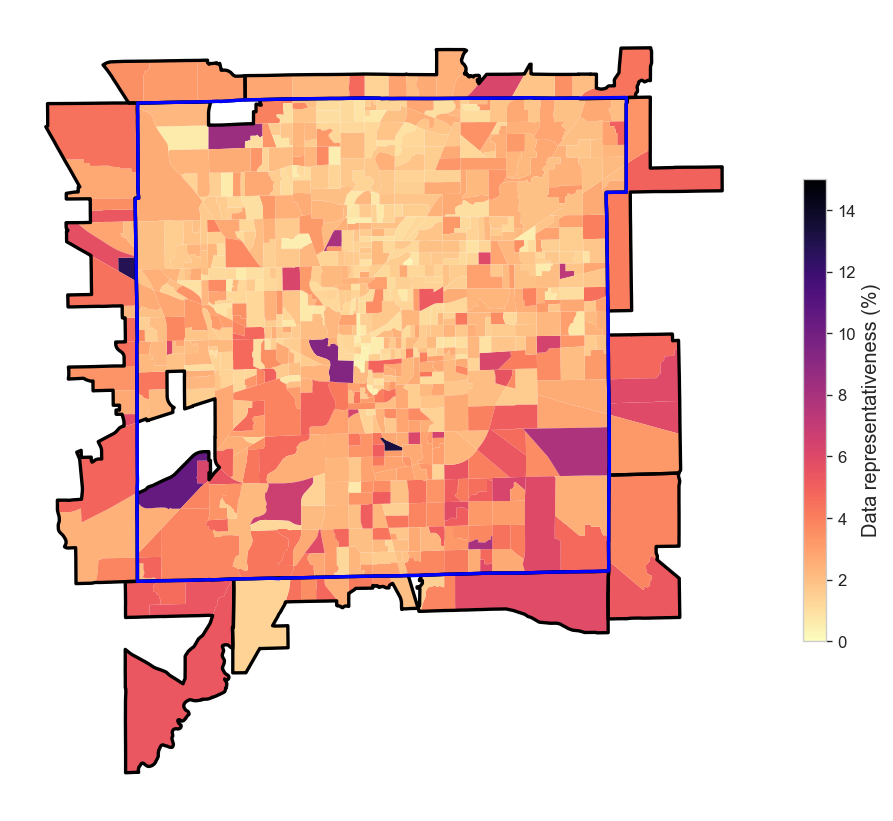

In [31]:
def plot_representativeness_cbg(rgn, homes_var, vmin=0, vmax=15,
                                size=(10, 10), dpi=120, cmap='magma_r'):
    homes = getattr(rgn, 'h' + homes_var).copy()
    homes = mk.geo.pdf2gdf(homes, LON, LAT, CRS_DEG)
    acs = gpd.read_file(rgn.data / f'geometry/acs.gpkg').query('popu > 0')
    homes = gpd.sjoin(homes, acs[['geometry', 'geoid']], predicate='within')
    n_users = homes.groupby('geoid').size().rename('n_users').reset_index()
    acs = acs.merge(n_users, on='geoid')[['county', 'n_users', 'popu', 'geometry']]
    acs['repres'] = (acs['n_users'] * 100) / acs['popu']
    ax = U.plot(size=size, dpi=dpi, axoff=1)
    acs = gpd.sjoin(acs, rgn.boundary)
    acs.to_crs(CRS_M).plot(
        ax=ax, column='repres', cmap=cmap, legend=True, 
        vmin=vmin, vmax=vmax, edgecolor='none', # classification_kwds=dict(bins=np.arange(vmin, vmax+1)),
        legend_kwds=dict(shrink=0.5, label='Data representativeness (%)'))
    counties = acs.groupby('county')['geometry'].agg(lambda x: x.unary_union).set_crs(CRS_DEG)
    counties.to_crs(CRS_M).plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2)
    rgn.boundary.to_crs(CRS_M).plot(ax=ax, facecolor='none', edgecolor='b', linewidth=2)

plot_representativeness_cbg(indy, 'A2')

# Miscellaneous

## Visualize

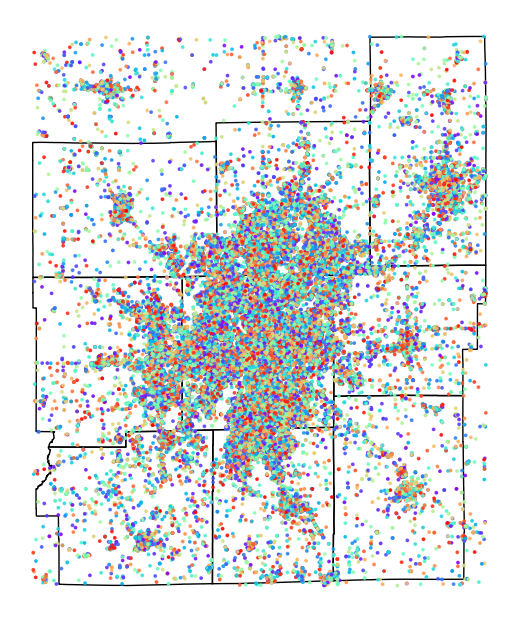

In [21]:
ax = U.plot(size=(8, 8), dpi=100, axoff=1)
indy.cnty.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=1)
mk.geo.pdf2gdf(h1.dropna(), 'lon', 'lat', CRS_DEG)\
.plot(ax=ax, column='uid', markersize=3, alpha=0.8, cmap='rainbow');